# **Snippets from studies not included at Euro-C paper**

Includes shear test 3D, tensile test axisymm, investigation of state variables profile at ligament

In [3]:
%matplotlib widget
import numpy as np
np.seterr(divide='ignore', invalid='ignore') 
import matplotlib.pylab as plt
from ibvpy.bcond import BCSlice, BCDof
from ibvpy.fets import FETS3D8H
from ibvpy.fets import FETS2D4Q
from ibvpy.tmodel.mats3D import MATS3DElastic
import bmcs_matmod.ms1.concrete_material_db as mp_db
from ibvpy.tmodel.viz3d_scalar_field import \
    Vis3DStateField, Viz3DScalarField
from ibvpy.tmodel.viz3d_tensor_field import \
    Vis3DTensorField, Viz3DTensorField
from ibvpy.sim.tstep_bc import TStepBC
from ibvpy.xmodel.xdomain_fe_grid import XDomainFEGrid
from ibvpy.xmodel.xdomain_fe_grid_axisym import XDomainFEGridAxiSym
from ibvpy.api import TStepBC, TFCyclicNonsymmetricConstant, TFBilinear
from mayavi import mlab
from bmcs_matmod.ms1 import MS13D
from ibvpy.tmodel.mats3D.mats3D_microplane.vmats3D_mpl_d_eeq import \
    MATS3DMplDamageEEQ
from ibvpy.bcond import BCSliceI, BCDof
from ibvpy.tfunction import TimeFunction, TFSelector, TFCyclicSin, TFCyclicNonsymmetricConstant
import copy

In [4]:
def get_damage(m):   
    radial_damage = []
    hoop_damage = []
    shear_damage = []

    for i in range(len(m.hist.state_vars)):
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        delta = m_inelastic.DELTA

        beta_ijkl = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        radial_damage.append(1-(beta_ijkl**2)[0,1,1,1,1])
        hoop_damage.append(1-(beta_ijkl**2)[0,2,2,2,2])
        shear_damage.append(1-((beta_ijkl)[0,1,0,1,0]*2)**2)
    return radial_damage, hoop_damage, shear_damage


In [5]:
def get_omega_N(m):
    omega_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_N_11[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_N_01[i] = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
    return omega_N_01, omega_N_11 

In [6]:
def get_omega_T(m):
    omega_T_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        omega_T_11[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        
    omega_T_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        omega_T_01[i] = np.array([ m.hist.state_vars[i][0]['omega_T_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        
    return omega_T_01, omega_T_11   

In [7]:
def get_sigma_N(m):
    
    sigma_N_11 = np.zeros((len(m.hist.state_vars),8))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn_2(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [8, 9, 10,11, 16, 17, 18 ,19]])
        sigma_N_11[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
        
    sigma_N_01 = np.zeros((len(m.hist.state_vars),20))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        eps_N_Emn = m_inelastic._get_e_N_Emn_2(eps_Emab)
        eps_N_Emn = np.array([ eps_N_Emn[0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        E_N = m_inelastic.E / (1.0 - 2.0 * m_inelastic.nu)
        omega_N_Emn = np.array([ m.hist.state_vars[i][0]['omega_N_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        eps_N_p_Emn = np.array([ m.hist.state_vars[i][0]['eps_N_p_Emn'][0,0][j] for j in [0,1,2,3,4,5,6,7,12,13,14,15,20,21,22,23,24,25,26,27]])
        sigma_N_01[i] = (1.0 - omega_N_Emn ) * E_N * (eps_N_Emn - eps_N_p_Emn)
    
    sigma_radial = np.zeros(len(m.hist.state_vars))
    for i in range(len(m.hist.state_vars)):
        eps_Emab = xmodel.map_U_to_field(m.hist.U_t[i])
        omega_T_Emn = np.average(m.hist.state_vars[i][0]['omega_T_Emn'],axis=1)
        omega_N_Emn = np.average(m.hist.state_vars[i][0]['omega_N_Emn'],axis=1)
        eps_T_pi_Emna = np.average(m.hist.state_vars[i][0]['eps_T_pi_Emna'],axis=1)
        eps_N_p_Emn = np.average(m.hist.state_vars[i][0]['eps_N_p_Emn'],axis=1)
        
        beta_N = 1. - omega_N_Emn
        beta_T = 1. - omega_T_Emn
        delta = m_inelastic.DELTA

        beta_Emabcd = np.einsum('n, ...n,ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_N, m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN,
                              m_inelastic._MPN) + \
                    0.25 * (np.einsum('n, ...n,ni, nk, jl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,ni, nl, jk -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nk, il -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) +
                            np.einsum('n, ...n,nj, nl, ik -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN, m_inelastic._MPN, delta) -
                            4.0 * np.einsum('n, ...n, ni, nj, nk, nl -> ...ijkl', m_inelastic._MPW, beta_T, m_inelastic._MPN,
                                            m_inelastic._MPN, m_inelastic._MPN, m_inelastic._MPN))

        D_Emabcd = np.einsum(
                     '...ijab, abef, ...cdef->...ijcd',
                     beta_Emabcd, m_inelastic.D_abef, beta_Emabcd
                )

        eps_p_Emab = (
        np.einsum('n,...n,na,nb->...ab',
                  m_inelastic._MPW, eps_N_p_Emn, m_inelastic._MPN, m_inelastic._MPN) +
        0.5 * (
                np.einsum('n,...nf,na,fb->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA) +
                np.einsum('n,...nf,nb,fa->...ab',
                          m_inelastic._MPW, eps_T_pi_Emna, m_inelastic._MPN, m_inelastic.DELTA)
        )
        )
        eps_e_Emab = eps_Emab - eps_p_Emab

        sig_Emab = np.einsum(
            '...abcd,...cd,...ab->...ab',
            D_Emabcd, eps_e_Emab, m_inelastic.DELTA
                ) 
        sigma_11 = sig_Emab[0,:,1,1]
        sigma_radial[i] = max(sigma_11)
        
    return sigma_N_01, sigma_N_11, sigma_radial

## Shear test

In [8]:
CAxisymm = dict(
    E = 42e+3,
    nu = 0.2,
    Ad = 18000.0,
    eps_0 = 0.0001,
    K_N = 17000.,
    sigma_N_0 = 45.,
    gamma_N = 9000.,
    sigma_T_0 = 2.0,
    K_T = 20000.0,
    gamma_T = 500000,
    S_T = 0.0075,
    c_T = 9.,
    r_T = 15.,
    m_T = 0.004,
    p_T = 10.
)

In [9]:
size_x = 1
size_y = 1
size_z = 1
n_e_x = 1
n_e_y = 1
n_e_z = 1

xmodel = XDomainFEGrid(coord_min=(0, 0, 0),
                       coord_max=(size_x ,size_y, size_z),
                       shape=(n_e_x, n_e_y, n_e_z),
                     integ_factor=1,
                     fets=FETS3D8H())

m_inelastic = MS13D(**CAxisymm)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [10]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [11]:
w_max = -0.005

# Uniaxial tension/compression


support = BCSlice(slice=xmodel.mesh[0, :, :, 0, :, :],
                 var='u', dims=[0,1,2], value=0.0)

slide_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[1], value=w_max)
slide_dofs = slide_slice.dofs
slide = [BCDof(var='u', dof=dof, value=w_max , time_function=tf_sliding) 
                     for dof in slide_dofs ]

back_side = BCSlice(slice=xmodel.mesh[0, :, :, :, :, 0],
                 var='u', dims=[2], value=0.0)

compression_slice = BCSlice(slice=xmodel.mesh[-1, :, :, -1, :, :],
                 var='u', dims=[0], value=0.0)
compression_dofs = compression_slice.dofs
compression_force = 0 * (size_y*size_z) / len(compression_dofs)
compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]


In [12]:
support.dofs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [13]:
xmodel.mesh[:, :, :, 0, -1, 0].dofs

array([[[6, 7, 8]]])

In [14]:
bc1 = [support, slide_slice, compression_slice, back_side]

In [18]:
m.bc=bc1
# m.hist.vis_record = {
#     'stress': Vis3DTensorField(var='sig_ab'),
#     # 'damage': Vis3DTensorField(var='omega_ab'),
#     #        'kinematic hardening': Vis3DStateField(var='z_a')
# }

m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    'damage': Vis3DTensorField(var='omega_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
try:
    s.run()
except:
    pass

In [19]:
m.hist.vis_record['stress']

132.20655536333703
0.13220655536333703


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
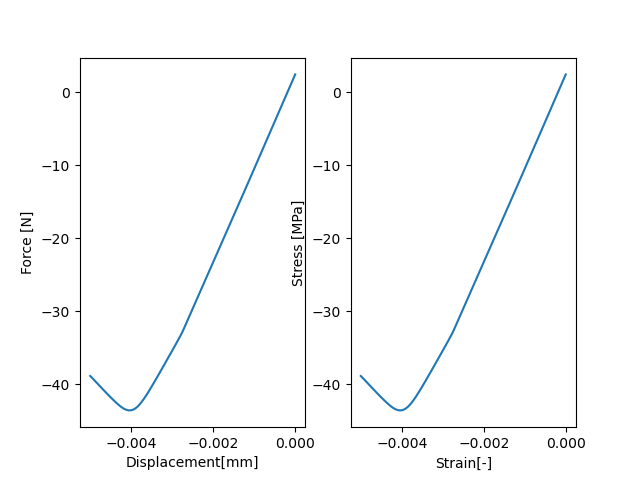

In [20]:
U_last = m.hist.U_t[-1]
F_last = m.hist.U_t[-1]
U_t = np.average(m.hist.U_t[:, slide_dofs], axis=-1)
F_t = np.sum(m.hist.F_t[:, slide_dofs], axis=-1)
fig, (ax1,ax2) = plt.subplots(1, 2)
ax1.plot(U_t, F_t)
ax1.set_ylabel('Force [N]')
ax1.set_xlabel('Displacement[mm]')
ax2.plot(U_t/size_x, F_t/(size_y*size_z))
ax2.set_ylabel('Stress [MPa]')
ax2.set_xlabel('Strain[-]')
G = np.trapz(F_t, x=U_t)/((size_z)*(size_y))*1000
G2 = np.trapz(F_t/(size_y*size_z), x=U_t/size_x)
print(G)
print(G2)

In [21]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

# Unit element axisymmetric

In [22]:
CAxisymm = dict(
    E = 40e+3,
    nu = 0.2,
    Ad = 7000.0,
    eps_0 = 0.00001,
    K_N = 1000.,
    sigma_N_0 = 40.,
    gamma_N = 20000.,
    sigma_T_0 = 2.0,
    K_T = 5000.0,
    gamma_T = 10000,
    S_T = 0.004,
    c_T = 5.,
    r_T = 8.,
    m_T = 0.2,
    p_T = 8.
)

## Tensile test

In [23]:
n_x_e = 3
n_inner_y_e = 1
n_outer_y_e = 1
L_x = 90.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 4 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [24]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=1.0)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=1.0)

In [25]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs

In [26]:
w_max = 0.003

m = TStepBC(
domains=[(xmodel, m_inelastic),
         ]
)

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice

upper_compression_force = [BCDof(var='u', dof=dof, value=w_max, 
                                 time_function=tf_precrompression)
                           for dof in confinement_upper_dofs]

bc1 = [inner_fixed_0, inner_fixed_1] + upper_compression_force

m.bc=bc1
m.hist.vis_record = {
   'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = False
s.tloop.k_max = 1000
s.tline.step = 0.02
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains
s.reset()
s.run()


In [34]:
idx = 40
U_last = m.hist.U_t[idx]

In [35]:
eps_Emab = m.fe_domain[0].xmodel.map_U_to_field(U_last)
eps_Emab

array([[[[ 5.94095664e-06, -3.04331163e-05,  0.00000000e+00],
         [-3.04331163e-05,  6.00000000e-04,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.96236719e-05]],

        [[ 5.94095664e-06,  3.04331163e-05,  0.00000000e+00],
         [ 3.04331163e-05,  6.00000000e-04,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  1.96236719e-05]],

        [[ 2.21719520e-05,  3.04331163e-05,  0.00000000e+00],
         [ 3.04331163e-05,  6.00000000e-04,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  6.72292827e-05]],

        [[ 2.21719520e-05, -3.04331163e-05,  0.00000000e+00],
         [-3.04331163e-05,  6.00000000e-04,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  6.72292827e-05]]]])

In [36]:
state_vars = m.hist.state_vars[idx][0]

In [37]:
m.fe_domain[0].tmodel.__class__

bmcs_matmod.ms1.ms1.MS13D

In [38]:
m.fe_domain[0].tmodel.get_corr_pred(eps_Emab,1,**state_vars)

(array([[[[-1.59455447, -0.37653932,  0.        ],
          [-0.37653932,  5.52954453,  0.        ],
          [ 0.        ,  0.        , -1.33925326]],
 
         [[-1.59455447,  0.37653932,  0.        ],
          [ 0.37653932,  5.52954453,  0.        ],
          [ 0.        ,  0.        , -1.33925326]],
 
         [[-1.56126525,  0.36594683,  0.        ],
          [ 0.36594683,  5.26626829,  0.        ],
          [ 0.        ,  0.        , -0.89602403]],
 
         [[-1.56126525, -0.36594683,  0.        ],
          [-0.36594683,  5.26626829,  0.        ],
          [ 0.        ,  0.        , -0.89602403]]]]),
 array([[[[[[28013.1689747 ,   771.38049682,     0.        ],
            [  771.38049682, -3979.88499347,     0.        ],
            [    0.        ,     0.        ,  1543.84210425]],
 
           [[  771.38049682,  8983.06822513,     0.        ],
            [ 8983.06822513,   153.11035875,     0.        ],
            [    0.        ,     0.        ,   281.94969554]],

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
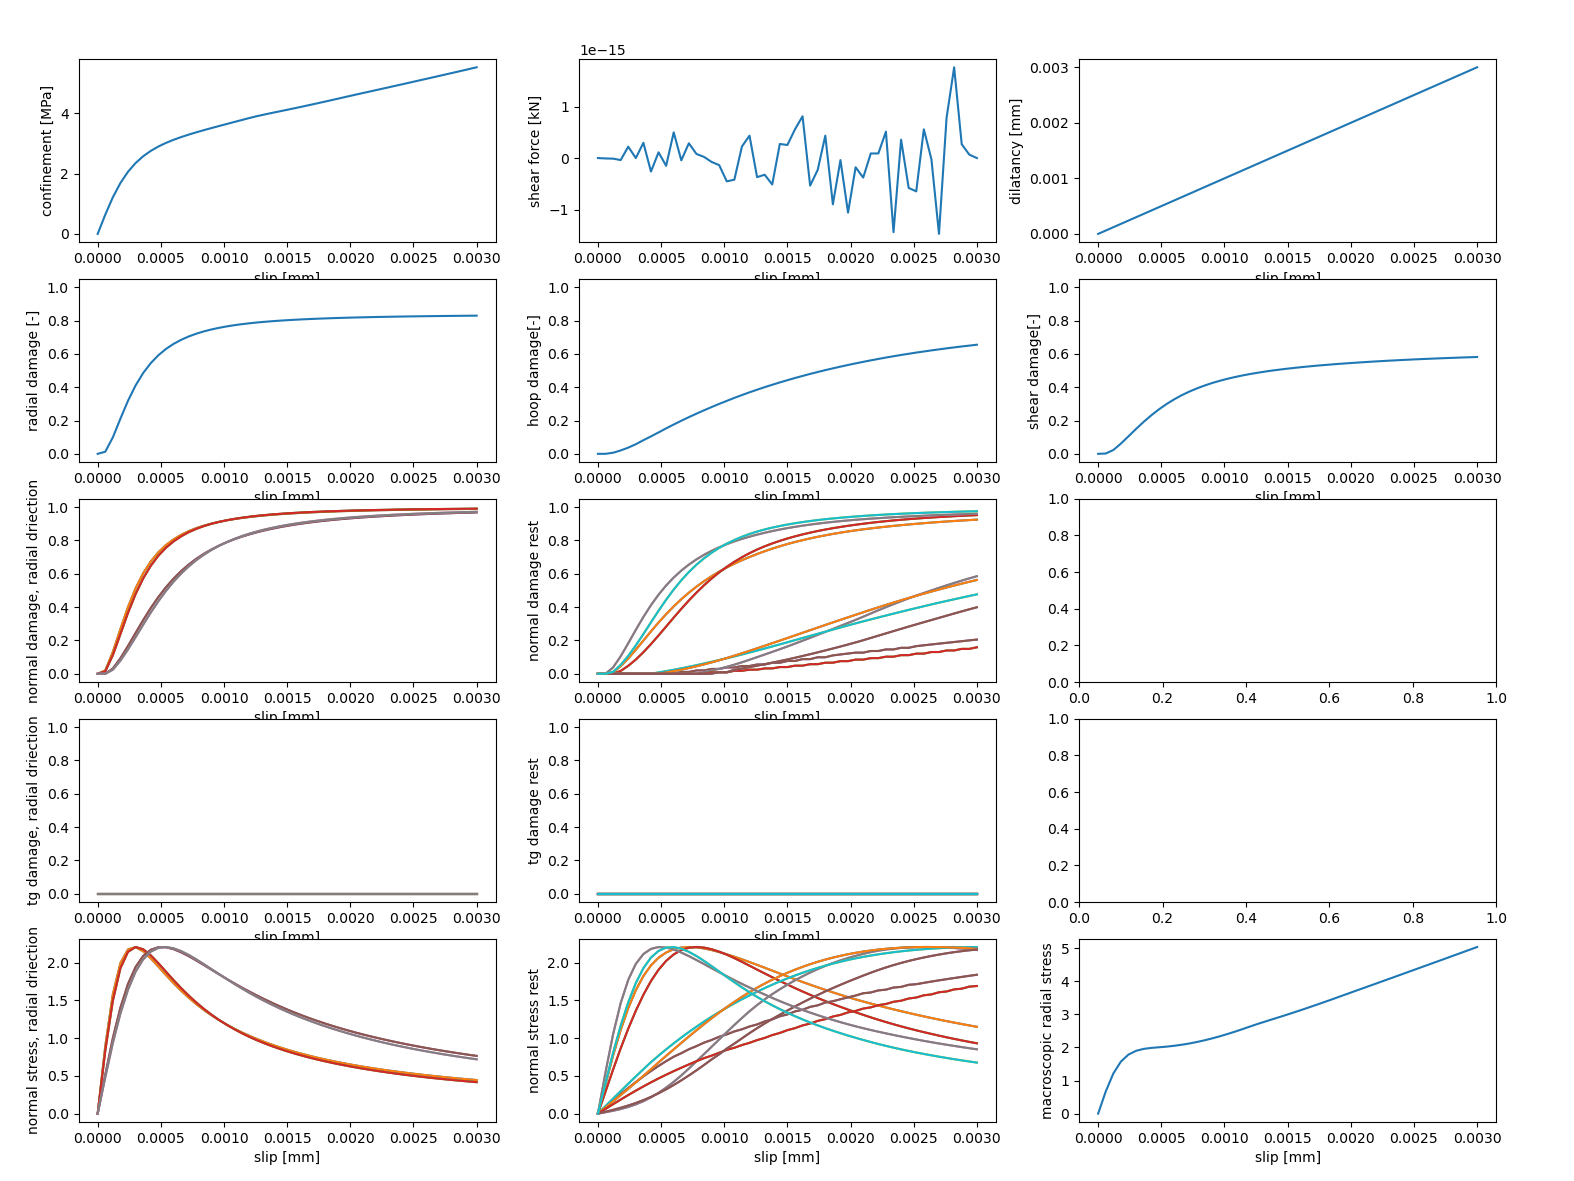

In [39]:
plt.style.use('default')

# plt.tight_layout()

cm = 1/2.54  # centimeters in inches
fig, ((ax1,ax2,ax3), (ax4,ax5,ax6), (ax7,ax8,ax9), (ax10,ax11,ax12), (ax13,ax14,ax15)) = plt.subplots(5, 3,figsize=(40*cm, 30*cm))

# txt=str(CAxisymm)


idx = 2
# m = m_list_monotnonic[idx]
# compression = compression_level[idx]
# plt.rcParams["font.family"] = "Times New Roman"
compression = 0
    
U_slide = np.average(m.hist.U_t[:, slide_upper_dofs], axis=-1)
U_dilatancy  =m.hist.U_t[:, confinement_upper_dofs[0]]
F_slide = np.sum(m.hist.F_t[:, slide_upper_dofs], axis=-1)
radial_damage, hoop_damage, shear_damage = get_damage(m)

F_confinement = np.sum(m.hist.F_t[:, confinement_upper_dofs], axis=-1)


ax1.plot(U_dilatancy, F_confinement/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)), label=str(compression))
ax1.set_ylabel('confinement [MPa]', fontsize=10)
ax1.set_xlabel('slip [mm]', fontsize=10)

ax2.plot(U_dilatancy, F_slide/1000, label=str(compression))
ax2.set_ylabel('shear force [kN]', fontsize=10)
ax2.set_xlabel('slip [mm]', fontsize=10)

ax3.plot(U_dilatancy, U_dilatancy, label=str(compression))
ax3.set_ylabel('dilatancy [mm]', fontsize=10)
ax3.set_xlabel('slip [mm]', fontsize=10)


# ax4.plot(U_slide, radial_damage, label='radial damage'+str(compression))
ax4.plot(U_dilatancy, radial_damage, label='radial damage'+str(compression))
ax4.set_ylabel('radial damage [-]', fontsize=10)
ax4.set_xlabel('slip [mm]', fontsize=10)
ax4.set_ylim(-0.05,1.05)

ax5.plot(U_dilatancy, hoop_damage, label='hoop damage'+str(compression))
ax5.set_ylabel('hoop damage[-]', fontsize=10)
ax5.set_xlabel('slip [mm]', fontsize=10)
ax5.set_ylim(-0.05,1.05)

# ax6.plot(F_slide/1000, shear_damage, label='shear damage'+str(compression))
ax6.plot(U_dilatancy, shear_damage, label='shear damage'+str(compression))
ax6.set_ylabel('shear damage[-]', fontsize=10)
ax6.set_xlabel('slip [mm]', fontsize=10)
ax6.set_ylim(-0.05,1.05)

omega_N_01, omega_N_11 = get_omega_N(m) 
ax7.plot(U_dilatancy, omega_N_11)
ax7.set_ylabel('normal damage, radial driection', fontsize=10)
ax7.set_xlabel('slip [mm]', fontsize=10)
ax7.set_ylim(-0.05,1.05)


ax8.plot(U_dilatancy, omega_N_01, label='shear damage'+str(compression))
ax8.set_ylabel('normal damage rest', fontsize=10)
ax8.set_xlabel('slip [mm]', fontsize=10)
ax8.set_ylim(-0.05,1.05)

omega_T_01, omega_T_11 = get_omega_T(m) 
ax10.plot(U_dilatancy, omega_T_11)
ax10.set_ylabel('tg damage, radial driection', fontsize=10)
ax10.set_xlabel('slip [mm]', fontsize=10)
ax10.set_ylim(-0.05,1.05)


ax11.plot(U_dilatancy, omega_T_01, label='shear damage'+str(compression))
ax11.set_ylabel('tg damage rest', fontsize=10)
ax11.set_xlabel('slip [mm]', fontsize=10)
ax11.set_ylim(-0.05,1.05)
    
sigma_N_01, sigma_N_11, sigma_radial = get_sigma_N(m) 
ax13.plot(U_dilatancy, sigma_N_11)
ax13.set_ylabel('normal stress, radial driection', fontsize=10)
ax13.set_xlabel('slip [mm]', fontsize=10)
# ax13.set_ylim(-0.05,1.05)


ax14.plot(U_dilatancy, sigma_N_01, label='shear damage'+str(compression))
ax14.set_ylabel('normal stress rest', fontsize=10)
ax14.set_xlabel('slip [mm]', fontsize=10)
# ax14.set_ylim(-0.05,1.05)

ax15.plot(U_dilatancy, sigma_radial)
ax15.set_ylabel('macroscopic radial stress', fontsize=10)
ax15.set_xlabel('slip [mm]', fontsize=10)

left  = 0.05  # the left side of the subplots of the figure
right = 0.95  # the right side of the subplots of the figure
bottom = 0.05   # the bottom of the subplots of the figure
top = 0.95      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


In [41]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Complete PTST - study about state variables profiles

In [45]:
n_x_e = 5
n_inner_y_e = 2
n_outer_y_e = 2
L_x = 50.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 2 # [mm]
R_out = 50 # [mm]
len_notch = 20
n_notch = 1
# geo_transform
# gmesh
xd_inner = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, 0),
                               coord_max=(L_x, R_in),
                               shape=(n_x_e, n_inner_y_e),
                               fets=FETS2D4Q())
xd_middle = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())
xd_outer = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0, R_in+dR),
                               coord_max=(L_x, R_out),
                               shape=(n_x_e, n_outer_y_e),
                               fets=FETS2D4Q())
m_elastic = MATS3DElastic(E=40000, nu=0.18)
# m_inelastic_MDM = MATS3DMplDamageEEQ(**CAxisymmMDM)


m_inelastic = MS13D(**CAxisymm)

m = TStepBC(
    domains=[(xd_inner, m_inelastic),
             (xd_outer, m_inelastic),
             (xd_middle, m_inelastic),
             ]
)

## Boundary and transition conditions

In [46]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

### Kinematic links between the domains

In [47]:
link_inner_middle_0 = BCSliceI(var='u', dims=[0],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_inner_middle_1 = BCSliceI(var='u', dims=[1],
                             # slice=xd_inner.mesh.I[:, -1], 
                             slice=xd_inner.mesh.I[n_notch:-n_notch, -1], 
                             link_slice=xd_middle.mesh.I[:, 0],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

link_middle_outer_0 = BCSliceI(var='u', dims=[0],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[0],
                             value=0,
                            )

link_middle_outer_1 = BCSliceI(var='u', dims=[1],
                             slice=xd_outer.mesh.I[n_notch:-n_notch, 0], 
                             # slice=xd_outer.mesh.I[:, 0], 
                             link_slice=xd_middle.mesh.I[:, -1],
                             link_coeffs=[1],
                             link_dims=[1],
                             value=0,
                            )

# link_middle_outer = BCSliceI(var='u', dims=[0, 1],
#                              slice=xd_middle.mesh.I[n_notch:-n_notch, 0], 
#                              # slice=xd_outer.mesh.I[:, 0], 
#                              link_slice=xd_outer.mesh.I[:, -1],
#                              link_coeffs=[1, 1],
#                              link_dims=[0, 1],
#                              value=0,
#                             )

## Sliding dc + Precompression fc

In [48]:
inner_fixed_1 = BCSliceI(slice=xd_inner.mesh.I[:, 0], var='u', dims=[1], value=0)
outer_fixed_0 = BCSliceI(slice=xd_outer.mesh.I[0, :], var='u', dims=[0], value=0)
outer_fixed_1 = BCSliceI(slice=xd_outer.mesh.I[:, -1], var='u', dims=[1], value=0)

inner_fixed_out_1 = BCSliceI(slice=xd_inner.mesh.I[:, -1], var='u', dims=[1], value=0)

slide = 1.00
inner_slide_slice = BCSliceI(slice=xd_inner.mesh.I[-1, :],
                                   var='u', dims=[0], value=-0.1)

slide_control_dofs = inner_slide_slice.dofs
inner_slide = [BCDof(var='u', dof=dof, value=-slide, time_function=tf_sliding) 
                     for dof in slide_control_dofs ]


outer_compression_slice = BCSliceI(slice=xd_outer.mesh.I[:, -1],
                                   var='u', dims=[1], value=-0.1)

compression_dofs = outer_compression_slice.dofs
compression_stress = -10
compression_force = compression_stress  * 2* np.pi* R_out * L_x / len(compression_dofs)
outer_compression_force_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs ]

compression_dofs_inner = inner_fixed_out_1.dofs
outer_compression_force_inner_first = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in compression_dofs_inner ]


# outer_compression_force_first = [BCDof(var='u', dof=dof, value=0.01, time_function=tf_precrompression) 
#                                  for dof in compression_dofs ]
# outer_compression_force_first[0].value *=0.5
# outer_compression_force_first[-1].value *=0.5
outer_compression_force_inner_first[0].value *=0.5
outer_compression_force_inner_first[-1].value *=0.5

bc1 =   [inner_fixed_1,
        outer_fixed_0,
        link_middle_outer_0,
         link_middle_outer_1,
        link_inner_middle_0,
         link_inner_middle_1
        ]  + inner_slide + outer_compression_force_first

In [49]:
ligament_upper_slide_slice = BCSliceI(slice=xd_middle.mesh.I[:, -1],
                                   var='u', dims=[0], value=-0.1)
ligament_upper_slide_dofs = ligament_upper_slide_slice.dofs

ligament_lower_slide_slice = BCSliceI(slice=xd_middle.mesh.I[:, 0],
                                   var='u', dims=[0], value=-0.1)
ligament_lower_slide_dofs = ligament_lower_slide_slice.dofs

ligament_upper_confinement_slice = BCSliceI(slice=xd_middle.mesh.I[:, -1],
                                   var='u', dims=[1], value=-0.1)
ligament_upper_confinement_dofs = ligament_upper_confinement_slice.dofs

ligament_lower_confinement_slice = BCSliceI(slice=xd_middle.mesh.I[:, 0],
                                   var='u', dims=[1], value=-0.1)
ligament_lower_confinement_dofs = ligament_lower_confinement_slice.dofs

In [50]:
m.bc=bc1
m.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s = m.sim
s.tloop.verbose = True
s.tloop.k_max = 1000
s.tline.step = 0.01
# Accessing the following property - ensures serialization
s.tstep.fe_domain.serialized_subdomains

In [51]:
s.reset()
s.run()

t:	 0.00(0), 
	 0.01(4), 
	 0.02(7), 
	 0.03(9), 
	 0.04(10), 
	 0.05(11), 
	 0.06(11), 
	 0.07(11), 
	 0.08(13), 
	 0.09(13), 
	 0.10(13), 
	 0.11(12), 
	 0.12(18), 
	 0.13(26), 
	 0.14

KeyboardInterrupt: 

## Postprocesing

### Access the last displacement step

In [52]:
F = m.hist.F_t
U = m.hist.U_t

In [53]:
F_slide = np.sum(F[:, slide_control_dofs], axis=-1)
F_slide_ligament_upper = np.sum(F[:, ligament_upper_slide_dofs], axis=-1)
F_slide_ligament_lower = np.sum(F[:, ligament_lower_slide_dofs], axis=-1)
F_confinement_ligament_upper = np.sum(F[:, ligament_upper_confinement_dofs], axis=-1)
F_confinement_ligament_lower = np.sum(F[:, ligament_lower_confinement_dofs], axis=-1)
U_slide = np.average(U[:, slide_control_dofs], axis=-1)
U_slide_ligament_upper = np.average(U[:, ligament_upper_slide_dofs], axis=-1)
U_slide_ligament_lower = np.average(U[:, ligament_lower_slide_dofs], axis=-1)
U_slide_differential_ligament = U_slide_ligament_upper - U_slide_ligament_lower

Text(0.5, 0, 'Displacement at control[mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
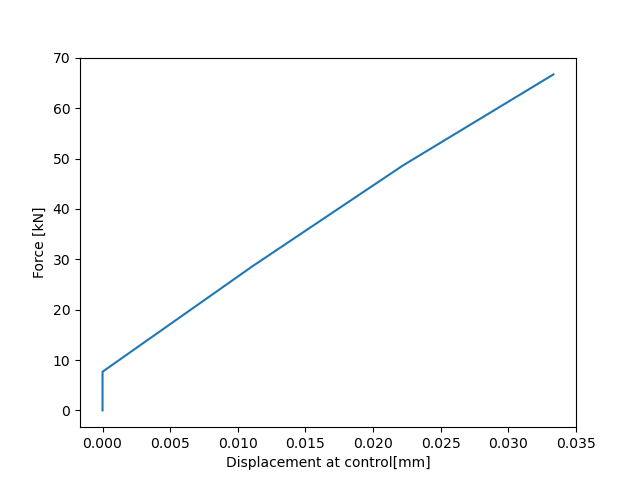

In [54]:
_, ax = plt.subplots(1,1)
ax.plot(-U_slide, -F_slide/1000)
ax.set_ylabel('Force [kN]')
ax.set_xlabel('Displacement at control[mm]')
# ax.legend()

Text(0.5, 0, 'Diferential displacement at ligament [mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
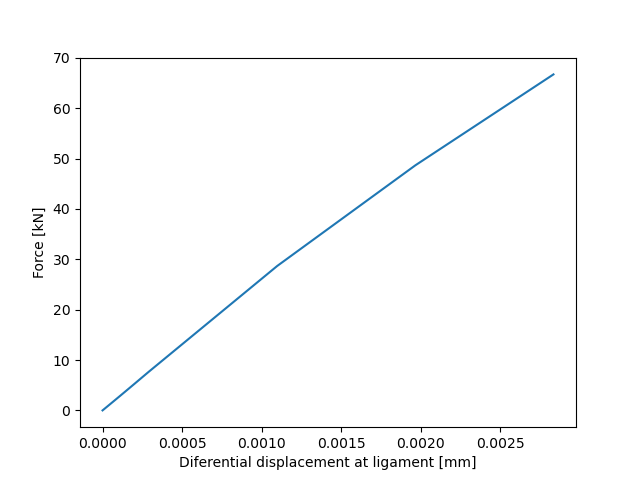

In [55]:
_, ax = plt.subplots(1,1)
ax.plot(abs(U_slide_differential_ligament), F_slide_ligament_upper/1000)
ax.set_ylabel('Force [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
# ax.legend()
# abs(U_slide_middle_inner - U_slide_middle)[-1]

Text(0.5, 0, 'Displacement at control [mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
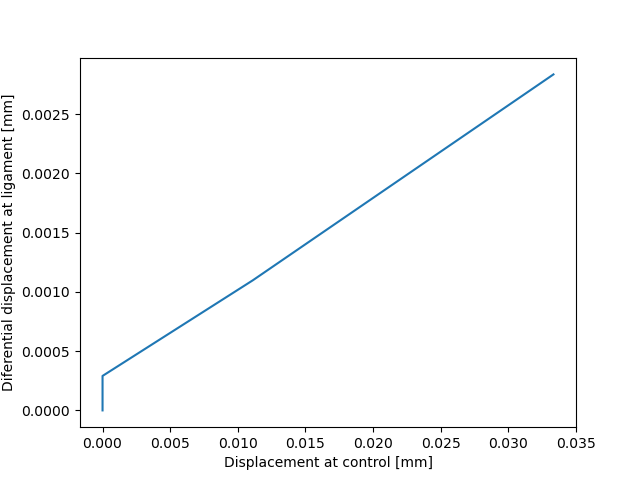

In [56]:
_, ax = plt.subplots(1,1)
ax.plot(-U_slide, abs(U_slide_differential_ligament))
ax.set_ylabel('Diferential displacement at ligament [mm]')
ax.set_xlabel('Displacement at control [mm]')
# ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
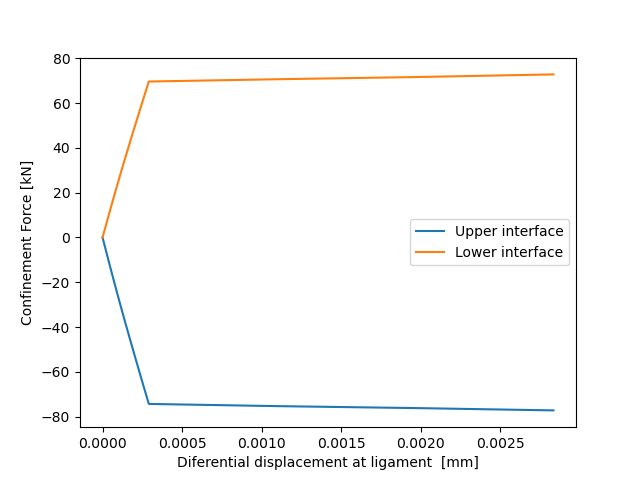

In [57]:
_, ax = plt.subplots(1,1)
ax.plot(U_slide_differential_ligament, F_confinement_ligament_upper/1000, label='Upper interface')
ax.plot(U_slide_differential_ligament, F_confinement_ligament_lower/1000, label='Lower interface')
ax.set_ylabel('Confinement Force [kN]')
ax.set_xlabel('Diferential displacement at ligament  [mm]')
ax.legend()

### Study about slide profile at ligament

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
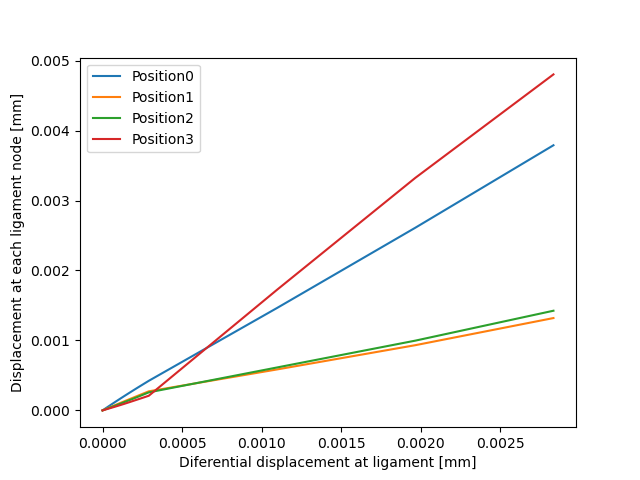

In [58]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    # ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i], label=str(i))
    # ax.plot(U_slide_differential_ligament, U[:, ligament_lower_slide_dofs][:,i], label=str(i))
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i], label='Position' + str(i))
ax.set_ylabel('Displacement at each ligament node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
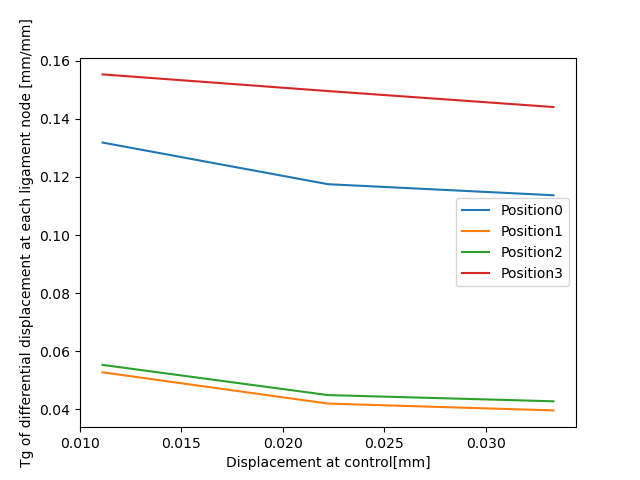

In [59]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(-U_slide, ((U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i]))/-(U_slide), label='Position' + str(i))
    # print(((U[:, middle_confinement_dofs][:,i] - U[:, middle_confinement_inner_dofs][:,i])/-(U_slide))[-1])
ax.set_ylabel('Tg of differential displacement at each ligament node [mm/mm]')
ax.set_xlabel('Displacement at control[mm]')
ax.legend()

### Study about confinement profile at ligament

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
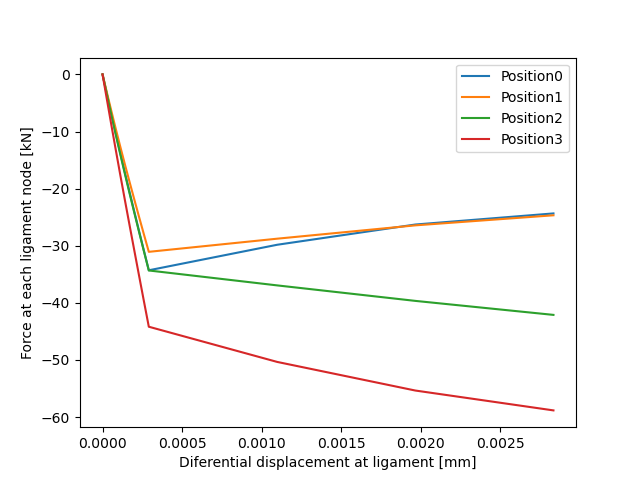

In [60]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    # ax.plot(U_slide_differential_ligament[:], F[:, ligament_upper_confinement_dofs][:,i]/1000, label=str(i))
    # ax.plot(U_slide_differential_ligament[:], F[:, ligament_lower_confinement_dofs][:,i]/1000, label=str(i))
    ax.plot(U_slide_differential_ligament, (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/1000, label='Position' + str(i))
ax.set_ylabel('Force at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

-730319.0320643905
-740083.7676631234
-1263323.5670272498
-1765058.5246108344


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
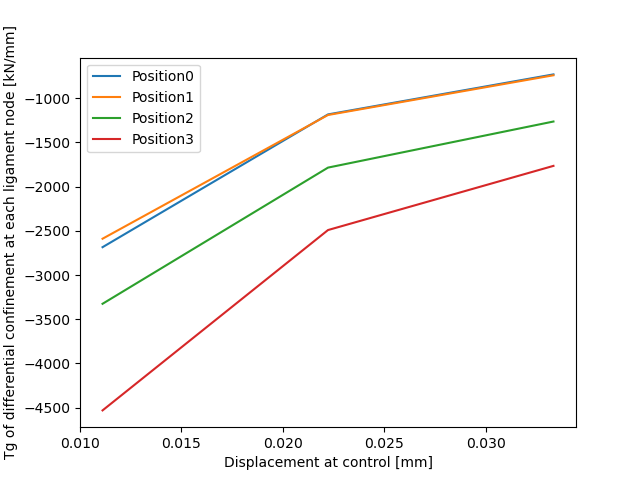

In [61]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    #ax.plot(-U_slide[:], (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/ (2* np.pi* R_out * L_x ), label=str(i))
    ax.plot(-U_slide[:], ((F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/ 1000)/-(U_slide), label='Position' + str(i))
    print(((F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/-(U_slide))[-1])
ax.set_ylabel('Tg of differential confinement at each ligament node [kN/mm]')
ax.set_xlabel('Displacement at control [mm]')
ax.legend()

### Study about dilatancy profile at ligament 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
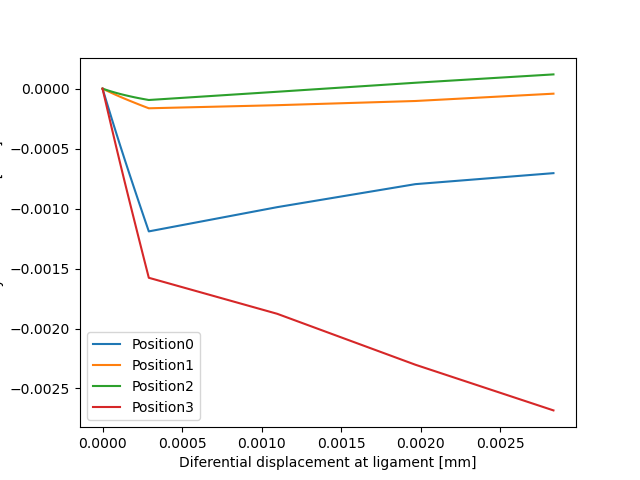

In [62]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    # ax.plot(U_slide_differential_ligament[:], U[:, ligament_upper_confinement_dofs][:,i], label= 'Position' + str(i))
    # ax.plot(U_slide_differential_ligament[:], U[:, ligament_lower_confinement_dofs][:,i], label= 'Position' + str(i))
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i], label = 'Position' + str(i))
ax.set_ylabel('Dilatancy at each node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()


Text(0.5, 0, 'Control displacement [mm]')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
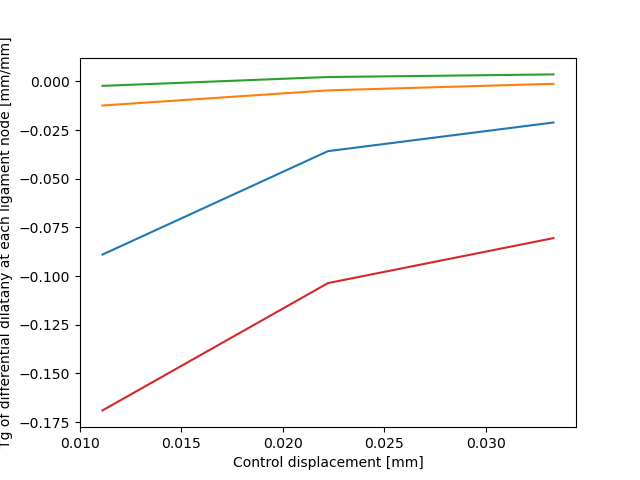

In [63]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(-(U_slide),  (U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i])/-(U_slide))
    # print((( U[:, middle_control_dofs][:,i] - U[:, middle_inner_control_dofs][:,i])/-(U_slide))[-1])
ax.set_ylabel('Tg of differential dilatany at each ligament node [mm/mm]')
ax.set_xlabel('Control displacement [mm]')
# ax.legend()

In [65]:
if False:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

## Unit element Axisymm

In [66]:
n_x_e = 3
n_inner_y_e = 1
n_outer_y_e = 1
L_x = 90.0 # [mm]
d_x = L_x / n_x_e
R_in = 25 # [mm]
dR = 4 # [mm]
R_out = 50 # [mm]
len_notch = 30
n_notch = 1

xmodel = XDomainFEGridAxiSym(integ_factor = 2 * np.pi,
                               coord_min=(0+n_notch*d_x, R_in),
                               coord_max=(L_x-n_notch*d_x, R_in+dR),
                               shape=(n_x_e-2*n_notch, 1),
                               fets=FETS2D4Q())

m_inelastic = MS13D(**CAxisymm)
m_elastic = MATS3DElastic(E=40000, nu=0.18)
m = TStepBC(
    domains=[(xmodel, m_inelastic),
             ]
)

In [67]:
tf_precrompression = TFBilinear(loading_ratio = 1.0, time_ratio=0.1)
tf_sliding = TFBilinear(loading_ratio = 0.0, time_ratio=0.1)

In [68]:
slide_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[0], value=0.0)
slide_upper_dofs = slide_upper_slice.dofs

slide_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[0], value=0.0)
slide_lower_dofs = slide_lower_slice.dofs

confinement_upper_slice = BCSliceI(slice=xmodel.mesh.I[:, -1],
                                   var='u', dims=[1], value=0.0)
confinement_upper_dofs = confinement_upper_slice.dofs

confinement_lower_slice = BCSliceI(slice=xmodel.mesh.I[:, 0],
                                   var='u', dims=[1], value=0.0)
confinement_lower_dofs = confinement_lower_slice.dofs


In [73]:
factor = 1

# Boundary conditions with inner side fixed

slide = 0.05
compression_stress = -0

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice

compression_force = compression_stress  * 2 * np.pi* R_out * L_x / len(confinement_upper_dofs)
upper_compression_force = [BCDof(var='f', dof=dof, value=compression_force, time_function=tf_precrompression) 
                                 for dof in confinement_upper_dofs ]
upper_compression_force[0].value *=0.5
upper_compression_force[-1].value *=0.5

slide_upper = [BCDof(var='u', dof=dof, value=slide , time_function=tf_sliding) 
                     for dof in slide_upper_dofs ]
bc1 = [inner_fixed_0, inner_fixed_1] + slide_upper #+ upper_compression_force

# Boundary conditions with differential definition of ligament bc

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice
delta_dilatancy = U[:, ligament_upper_confinement_dofs] - U[:, ligament_lower_confinement_dofs]
delta_confinement = F[:, ligament_upper_confinement_dofs] - F[:, ligament_lower_confinement_dofs]
delta_slide = U[:, ligament_upper_slide_dofs] - U[:, ligament_lower_slide_dofs]

confinement_upper_0 = BCDof(var='u', dof=confinement_upper_dofs[0], value=delta_dilatancy[-1,0]*factor, time_function=tf_sliding)
confinement_upper_1 = BCDof(var='u', dof=confinement_upper_dofs[1], value=delta_dilatancy[-1,1]*factor, time_function=tf_sliding)
confinement_upper_2 = BCDof(var='u', dof=confinement_upper_dofs[2], value=delta_dilatancy[-1,2]*factor, time_function=tf_sliding)
confinement_upper_3 = BCDof(var='u', dof=confinement_upper_dofs[3], value=delta_dilatancy[-1,3]*factor, time_function=tf_sliding)

slide_upper_0 = BCDof(var='u', dof=slide_upper_dofs[0], value=delta_slide[-1,0]*factor, time_function=tf_sliding)
slide_upper_1 = BCDof(var='u', dof=slide_upper_dofs[1], value=delta_slide[-1,1]*factor, time_function=tf_sliding)
slide_upper_2 = BCDof(var='u', dof=slide_upper_dofs[2], value=delta_slide[-1,2]*factor, time_function=tf_sliding)
slide_upper_3 = BCDof(var='u', dof=slide_upper_dofs[3], value=delta_slide[-1,3]*factor, time_function=tf_sliding)


bc2 =   [confinement_upper_0, slide_upper_0,
        confinement_upper_1, slide_upper_1,
        confinement_upper_2, slide_upper_2,
        confinement_upper_3, slide_upper_3,
        inner_fixed_0, inner_fixed_1] 


# Boundary conditions with differential slide definition of ligament bc

inner_fixed_0 = slide_lower_slice
inner_fixed_1 = confinement_lower_slice
delta_slide = U[:, ligament_upper_slide_dofs] - U[:, ligament_lower_slide_dofs]

slide_upper_0 = BCDof(var='u', dof=slide_upper_dofs[0], value=delta_slide[-1,0]*factor, time_function=tf_sliding)
slide_upper_1 = BCDof(var='u', dof=slide_upper_dofs[1], value=delta_slide[-1,1]*factor, time_function=tf_sliding)
slide_upper_2 = BCDof(var='u', dof=slide_upper_dofs[2], value=delta_slide[-1,2]*factor, time_function=tf_sliding)
slide_upper_3 = BCDof(var='u', dof=slide_upper_dofs[3], value=delta_slide[-1,3]*factor, time_function=tf_sliding)


bc3 =   [slide_upper_0,
        slide_upper_1, 
        slide_upper_2, 
        slide_upper_3, 
        inner_fixed_0, inner_fixed_1] 

# Boundary conditions with full definition of ligament bc


confinement_upper_0 = BCDof(var='f', dof=confinement_upper_dofs[0], value=F[:, ligament_upper_confinement_dofs][-1,0]*factor, time_function=tf_sliding)
confinement_upper_1 = BCDof(var='f', dof=confinement_upper_dofs[1], value=F[:, ligament_upper_confinement_dofs][-1,1]*factor, time_function=tf_sliding)
confinement_upper_2 = BCDof(var='f', dof=confinement_upper_dofs[2], value=F[:, ligament_upper_confinement_dofs][-1,2]*factor, time_function=tf_sliding)
confinement_upper_3 = BCDof(var='f', dof=confinement_upper_dofs[3], value=F[:, ligament_upper_confinement_dofs][-1,3]*factor, time_function=tf_sliding)

confinement_lower_0 = BCDof(var='f', dof=confinement_lower_dofs[0], value=F[:, ligament_lower_confinement_dofs][-1,0]*factor, time_function=tf_sliding)
confinement_lower_1 = BCDof(var='f', dof=confinement_lower_dofs[1], value=F[:, ligament_lower_confinement_dofs][-1,1]*factor, time_function=tf_sliding)
confinement_lower_2 = BCDof(var='f', dof=confinement_lower_dofs[2], value=F[:, ligament_lower_confinement_dofs][-1,2]*factor, time_function=tf_sliding)
confinement_lower_3 = BCDof(var='f', dof=confinement_lower_dofs[3], value=F[:, ligament_lower_confinement_dofs][-1,3]*factor, time_function=tf_sliding)

slide_upper_0 = BCDof(var='u', dof=slide_upper_dofs[0], value=U[:, ligament_upper_slide_dofs][-1,0]*factor, time_function=tf_sliding)
slide_upper_1 = BCDof(var='u', dof=slide_upper_dofs[1], value=U[:, ligament_upper_slide_dofs][-1,1]*factor, time_function=tf_sliding)
slide_upper_2 = BCDof(var='u', dof=slide_upper_dofs[2], value=U[:, ligament_upper_slide_dofs][-1,2]*factor, time_function=tf_sliding)
slide_upper_3 = BCDof(var='u', dof=slide_upper_dofs[3], value=U[:, ligament_upper_slide_dofs][-1,3]*factor, time_function=tf_sliding)

slide_lower_0 = BCDof(var='u', dof=slide_lower_dofs[0], value=U[:, ligament_lower_slide_dofs][-1,0]*factor, time_function=tf_sliding)
slide_lower_1 = BCDof(var='u', dof=slide_lower_dofs[1], value=U[:, ligament_lower_slide_dofs][-1,1]*factor, time_function=tf_sliding)
slide_lower_2 = BCDof(var='u', dof=slide_lower_dofs[2], value=U[:, ligament_lower_slide_dofs][-1,2]*factor, time_function=tf_sliding)
slide_lower_3 = BCDof(var='u', dof=slide_lower_dofs[3], value=U[:, ligament_lower_slide_dofs][-1,3]*factor, time_function=tf_sliding)


bc4 =   [confinement_upper_0, confinement_lower_0, slide_upper_0, slide_lower_0,
        confinement_upper_1, confinement_lower_1, slide_upper_1, slide_lower_1,
        confinement_upper_2, confinement_lower_2, slide_upper_2, slide_lower_2,
        confinement_upper_3, confinement_lower_3, slide_upper_3, slide_lower_3
            ] 

IndexError: index 2 is out of bounds for axis 0 with size 2

In [72]:
m1 = copy.deepcopy(m)
m1.bc=bc1
m1.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s1 = m1.sim
s1.tloop.verbose = False
s1.tloop.k_max = 1000
s1.tline.step = 0.005/factor
# Accessing the following property - ensures serialization
s1.tstep.fe_domain.serialized_subdomains
s1.reset()
s1.run()

KeyboardInterrupt: 

In [ ]:
U_t1 = np.average(m1.hist.U_t[:, slide_upper_dofs] - m1.hist.U_t[:, slide_lower_dofs], axis=-1)
F_t1 = np.sum(m1.hist.F_t[:, slide_upper_dofs], axis=-1)

In [ ]:
m2 = copy.deepcopy(m)
m2.bc=bc2
m2.hist.vis_record = {
#    'strain': Vis3DTensorField(var='eps_ab'),
    'stress': Vis3DTensorField(var='sig_ab'),
    #        'kinematic hardening': Vis3DStateField(var='z_a')
}

s2 = m2.sim
s2.tloop.verbose = False
s2.tloop.k_max = 1000
s2.tline.step = 0.005/factor
# Accessing the following property - ensures serialization
s2.tstep.fe_domain.serialized_subdomains
s2.reset()
s2.run()

In [ ]:
U_t2 = np.average(m2.hist.U_t[:, slide_upper_dofs] - m2.hist.U_t[:, slide_lower_dofs], axis=-1)
F_t2 = np.sum(m2.hist.F_t[:, slide_upper_dofs], axis=-1)

In [429]:
# m3 = copy.deepcopy(m)
# m3.bc=bc3
# m3.hist.vis_record = {
# #    'strain': Vis3DTensorField(var='eps_ab'),
#     'stress': Vis3DTensorField(var='sig_ab'),
#     #        'kinematic hardening': Vis3DStateField(var='z_a')
# }

# s3 = m3.sim
# s3.tloop.verbose = False
# s3.tloop.k_max = 1000
# s3.tline.step = 0.005/factor
# # Accessing the following property - ensures serialization
# s3.tstep.fe_domain.serialized_subdomains
# s3.reset()
# s3.run()

In [408]:
# U_t3 = np.average(m3.hist.U_t[:, slide_upper_dofs] - m3.hist.U_t[:, slide_lower_dofs], axis=-1)
# F_t3 = np.sum(m3.hist.F_t[:, slide_upper_dofs], axis=-1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
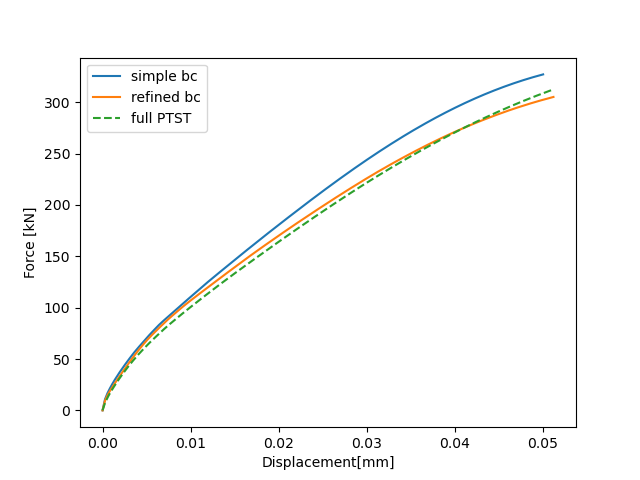

In [461]:
fig, (ax1) = plt.subplots(1)
ax1.plot(U_t1, F_t1/1000, label='simple bc')
ax1.plot(U_t2, F_t2/1000, label='refined bc')
# ax1.plot(U_t3, F_t3/1000, label='transferred bc')
ax1.plot(U_slide_differential_ligament, -F_slide/1000, '--', label='full PTST')
ax1.set_ylabel('Force [kN]')
ax1.set_xlabel('Displacement[mm]')
ax1.legend()
# ax2.plot(-U_t/(L_x-n_notch*2*d_x), -F_t/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)))
# # ax2.plot(-U_t/(L_x-n_notch*2*d_x), -F_t/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x)))
# # ax2.set_ylabel('Stress [MPa]')
# # ax2.set_xlabel('Strain[-]')
# G = np.trapz(F_t, x=U_t)/(2 * np.pi * (R_in+dR)*(L_x-n_notch*2*d_x))*1000
# G2 = np.trapz(F_t/(2 * np.pi * (R_in+dR)), x=U_t/(L_x-n_notch*2*d_x))
# print(G)
# print(G2)
# print(max(-F_t/1000))

In [315]:
if True:
    mlab.options.backend = 'envisage'
    mlab.options.offscreen = False # 'envisage'
    f_strain = mlab.figure()
    scene = mlab.get_engine().scenes[-1]
    scene.name = 'stress'
    strain_viz = Viz3DTensorField(vis3d=m.hist['stress'])
    strain_viz.setup()
    strain_viz.warp_vector.filter.scale_factor = 0.1
    strain_viz.plot(s.tstep.t_n)
    mlab.show()

In [137]:
# m.fe_domain[2].state_k

## Postprocesing

### Study about slide profile at ligament - PTST vs simple bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
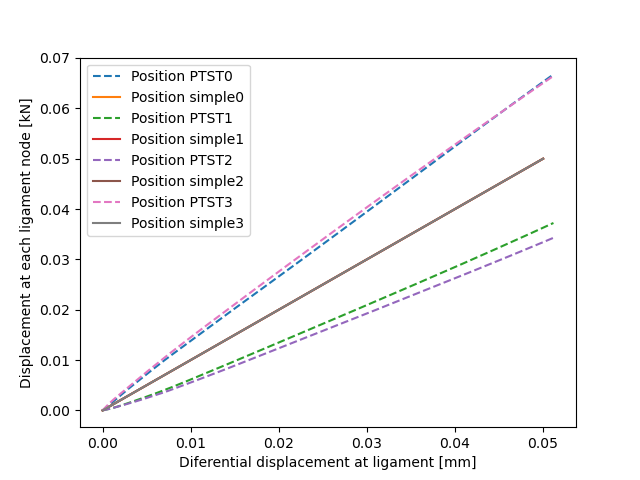

In [462]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i], '--', label='Position PTST' + str(i))
    ax.plot(U_t1, m1.hist.U_t[:, slide_upper_dofs][:,i] - m1.hist.U_t[:, slide_lower_dofs][:,i], label='Position simple' + str(i))
ax.set_ylabel('Displacement at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()



### Study about slide profile at ligament - PTST vs refined bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
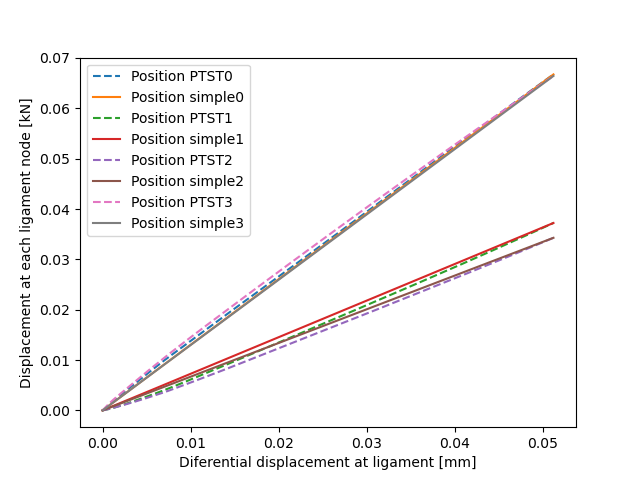

In [463]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_slide_dofs][:,i] - U[:, ligament_lower_slide_dofs][:,i], '--', label='Position PTST' + str(i))
    ax.plot(U_t2, m2.hist.U_t[:, slide_upper_dofs][:,i] - m2.hist.U_t[:, slide_lower_dofs][:,i], label='Position simple' + str(i))
ax.set_ylabel('Displacement at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

### Study about confinement profile at ligament - PTST vs simple bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
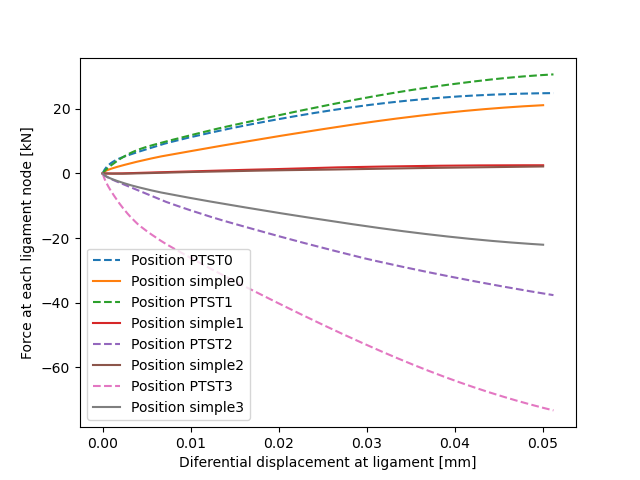

In [464]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/1000, '--', label='Position PTST' + str(i))
    ax.plot(U_t1, (m1.hist.F_t[:, confinement_upper_dofs][:,i]- m1.hist.F_t[:, confinement_lower_dofs][:,i])/1000, label='Position simple' + str(i))
ax.set_ylabel('Force at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

### Study about slide profile at ligament - PTST vs refined bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
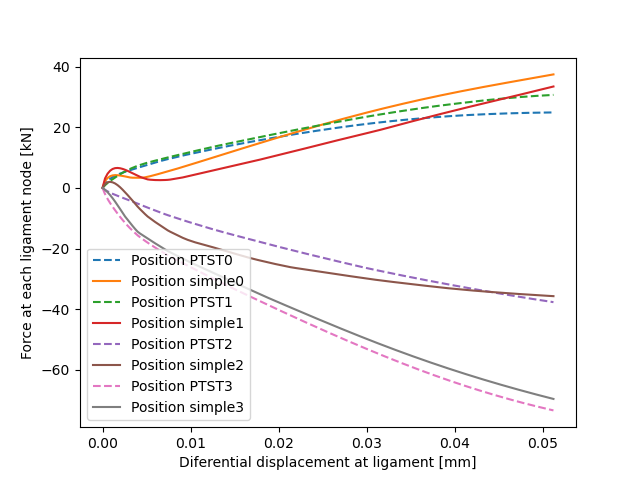

In [465]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, (F[:, ligament_upper_confinement_dofs][:,i] - F[:, ligament_lower_confinement_dofs][:,i])/1000, '--',label='Position PTST' + str(i))
    ax.plot(U_t2, (m2.hist.F_t[:, confinement_upper_dofs][:,i] - m2.hist.F_t[:, confinement_lower_dofs][:,i])/1000, label='Position simple' + str(i))
ax.set_ylabel('Force at each ligament node [kN]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()

### Study about dilatancy profile at ligament - PTST vs simple bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
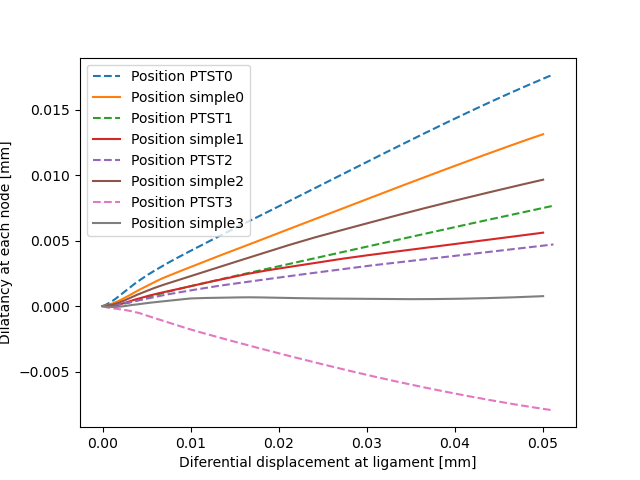

In [466]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i], '--', label = 'Position PTST' + str(i))
    ax.plot(U_t1, (m1.hist.U_t[:, confinement_upper_dofs][:,i] - m1.hist.U_t[:, confinement_lower_dofs][:,i]), label='Position simple' + str(i))
ax.set_ylabel('Dilatancy at each node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()


### Study about dilatancy profile at ligament - PTST vs refined bc

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
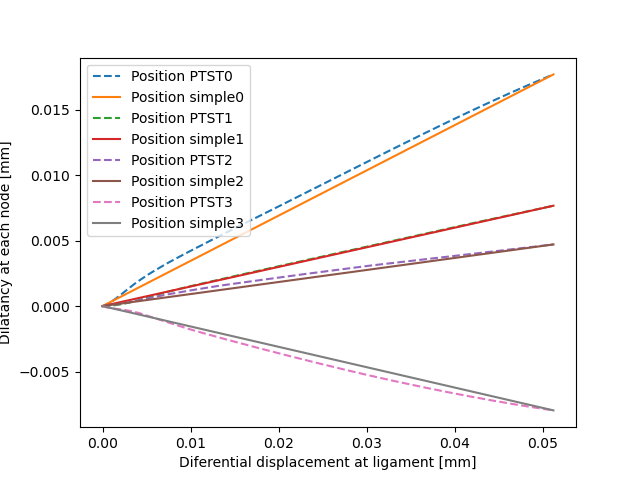

In [467]:
_, ax = plt.subplots(1,1)
for i in range(F[:, ligament_upper_confinement_dofs].shape[1]):
    ax.plot(U_slide_differential_ligament, U[:, ligament_upper_confinement_dofs][:,i] - U[:, ligament_lower_confinement_dofs][:,i], '--', label = 'Position PTST' + str(i))
    ax.plot(U_t2, (m2.hist.U_t[:, confinement_upper_dofs][:,i] - m2.hist.U_t[:, confinement_lower_dofs][:,i]), label='Position simple' + str(i))
ax.set_ylabel('Dilatancy at each node [mm]')
ax.set_xlabel('Diferential displacement at ligament [mm]')
ax.legend()
